In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-dataset-over-2m/recipes_data.csv


In [1]:
import pandas as pd
import json
import numpy as np
from scipy.sparse import lil_matrix
import networkx as nx
from collections import defaultdict

# Load the dataset
train_df = pd.read_json('/kaggle/input/recipe-ingredients-dataset/train.json')

print(f"Dataset shape: {train_df.shape}")
print(f"Cuisines: {train_df['cuisine'].nunique()}")
print(f"Sample recipe:\n{train_df.iloc[0]}")


Dataset shape: (39774, 3)
Cuisines: 20
Sample recipe:
id                                                         10259
cuisine                                                    greek
ingredients    [romaine lettuce, black olives, grape tomatoes...
Name: 0, dtype: object


In [2]:
# Get all unique ingredients
all_ingredients = []
for ingredients in train_df['ingredients']:
    all_ingredients.extend(ingredients)

unique_ingredients = list(set(all_ingredients))
print(f"Total unique ingredients: {len(unique_ingredients)}")


Total unique ingredients: 6714


In [3]:
# Clean and standardize ingredient names
def clean_ingredient(ingredient):
    return ingredient.lower().strip()

train_df['ingredients_clean'] = train_df['ingredients'].apply(
    lambda x: [clean_ingredient(ing) for ing in x]
)

# Filter out very rare or very common ingredients (optional)
ingredient_counts = defaultdict(int)
for ingredients in train_df['ingredients_clean']:
    for ingredient in ingredients:
        ingredient_counts[ingredient] += 1

# Keep ingredients that appear in 5-500 recipes
min_freq, max_freq = 5, 500
filtered_ingredients = {ing for ing, count in ingredient_counts.items() 
                       if min_freq <= count <= max_freq}

print(f"Filtered ingredients: {len(filtered_ingredients)} (from {len(ingredient_counts)})")

# Apply filter
train_df['ingredients_filtered'] = train_df['ingredients_clean'].apply(
    lambda x: [ing for ing in x if ing in filtered_ingredients]
)

# Remove recipes with no remaining ingredients
train_df = train_df[train_df['ingredients_filtered'].str.len() > 0]
print(f"Recipes after filtering: {len(train_df)}")


Filtered ingredients: 3183 (from 6703)
Recipes after filtering: 39023


In [4]:
# Create recipe-to-index mapping
recipes = train_df['id'].tolist()
num_recipes = len(recipes)
recipe_to_index = {recipe_id: idx for idx, recipe_id in enumerate(recipes)}

# Create sparse overlap matrix
overlap_matrix = lil_matrix((num_recipes, num_recipes), dtype=np.int32)

# Build ingredient-to-recipes mapping
ingredient_to_recipes = defaultdict(list)
for _, row in train_df.iterrows():
    recipe_idx = recipe_to_index[row['id']]
    for ingredient in row['ingredients_filtered']:
        ingredient_to_recipes[ingredient].append(recipe_idx)

# Fill overlap matrix efficiently
for ingredient, recipe_indices in ingredient_to_recipes.items():
    # Skip ingredients that appear in too many recipes (creates too many edges)
    if len(recipe_indices) <= 200:  # Adjust threshold as needed
        for i in range(len(recipe_indices)):
            for j in range(i + 1, len(recipe_indices)):
                idx_i, idx_j = recipe_indices[i], recipe_indices[j]
                overlap_matrix[idx_i, idx_j] += 1
                overlap_matrix[idx_j, idx_i] += 1

print(f"Overlap matrix created: {overlap_matrix.shape}")
print(f"Non-zero entries: {overlap_matrix.nnz}")


Overlap matrix created: (39023, 39023)
Non-zero entries: 7805664


In [5]:
# Convert sparse matrix to NetworkX graph
G = nx.Graph()

# Add nodes with recipe metadata
for _, row in train_df.iterrows():
    G.add_node(row['id'], cuisine=row['cuisine'], 
               ingredients=row['ingredients_filtered'])

# Extract edges from sparse matrix
overlap_coo = overlap_matrix.tocoo()
min_shared = 2  # Minimum shared ingredients threshold

edges_to_add = []
for i, j, weight in zip(overlap_coo.row, overlap_coo.col, overlap_coo.data):
    if i < j and weight >= min_shared:
        recipe_i = recipes[i]
        recipe_j = recipes[j]
        edges_to_add.append((recipe_i, recipe_j, {'weight': weight}))

G.add_edges_from(edges_to_add)
print(f"Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Network: 39023 nodes, 72231 edges


In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import collections

# Calculate basic network statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Calculate degree sequence
degree_sequence = [d for n, d in G.degree()]
avg_degree = np.mean(degree_sequence)
max_degree = max(degree_sequence)
min_degree = min(degree_sequence)

# Calculate clustering coefficient
avg_clustering = nx.average_clustering(G)

# Network density
density = nx.density(G)

print(f"Network Statistics:")
print(f"Nodes: {num_nodes:,}")
print(f"Edges: {num_edges:,}")
print(f"Average degree: {avg_degree:.2f}")
print(f"Max degree: {max_degree}")
print(f"Min degree: {min_degree}")
print(f"Average clustering coefficient: {avg_clustering:.4f}")
print(f"Network density: {density:.6f}")


Network Statistics:
Nodes: 39,023
Edges: 72,231
Average degree: 3.70
Max degree: 182
Min degree: 0
Average clustering coefficient: 0.2099
Network density: 0.000095


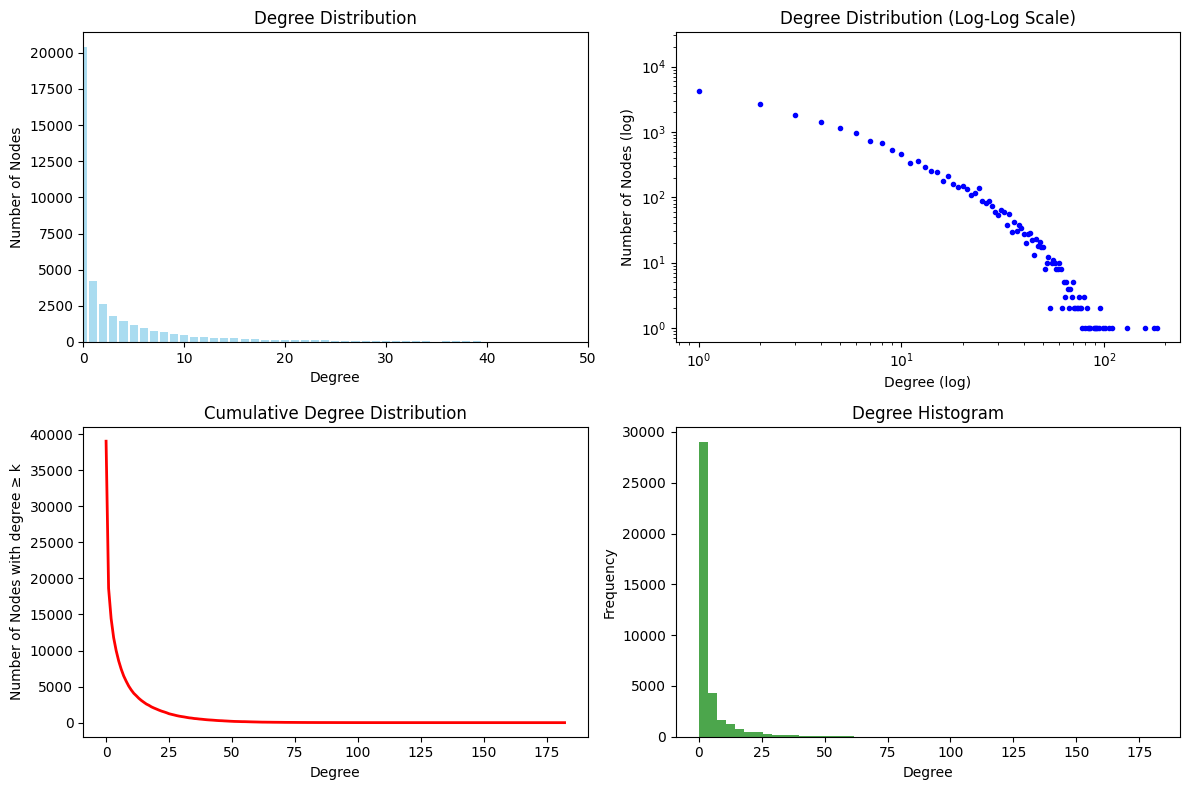

In [8]:
# Calculate degree distribution
degree_counts = collections.Counter(degree_sequence)
degrees, counts = zip(*sorted(degree_counts.items()))

# Plot degree distribution
plt.figure(figsize=(12, 8))

# Regular scale plot
plt.subplot(2, 2, 1)
plt.bar(degrees, counts, color='skyblue', alpha=0.7)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.xlim(0, 50)  # Focus on first 50 degrees for clarity

# Log-log scale plot
plt.subplot(2, 2, 2)
plt.loglog(degrees, counts, 'bo', markersize=3)
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (log)')
plt.ylabel('Number of Nodes (log)')

# Cumulative distribution
cumulative_counts = np.cumsum(counts[::-1])[::-1]
plt.subplot(2, 2, 3)
plt.plot(degrees, cumulative_counts, 'r-', linewidth=2)
plt.title('Cumulative Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes with degree ≥ k')

# Histogram of degrees
plt.subplot(2, 2, 4)
plt.hist(degree_sequence, bins=50, color='green', alpha=0.7)
plt.title('Degree Histogram')
plt.xlabel('Degree')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
# Detailed degree statistics
degree_stats = {
    'mean': np.mean(degree_sequence),
    'median': np.median(degree_sequence),
    'std': np.std(degree_sequence),
    'percentile_25': np.percentile(degree_sequence, 25),
    'percentile_75': np.percentile(degree_sequence, 75),
    'percentile_90': np.percentile(degree_sequence, 90),
    'percentile_95': np.percentile(degree_sequence, 95),
    'percentile_99': np.percentile(degree_sequence, 99)
}

print("\nDegree Distribution Statistics:")
for stat, value in degree_stats.items():
    print(f"{stat}: {value:.2f}")

# Top 10 most connected recipes
degree_dict = dict(G.degree())
top_recipes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 most connected recipes:")
for recipe_id, degree in top_recipes:
    print(f"Recipe {recipe_id}: {degree} connections")



Degree Distribution Statistics:
mean: 3.70
median: 0.00
std: 8.14
percentile_25: 0.00
percentile_75: 4.00
percentile_90: 11.00
percentile_95: 19.00
percentile_99: 40.00

Top 10 most connected recipes:
Recipe 29182: 182 connections
Recipe 1667: 175 connections
Recipe 26165: 158 connections
Recipe 25996: 130 connections
Recipe 41524: 109 connections
Recipe 29544: 105 connections
Recipe 2069: 101 connections
Recipe 40636: 99 connections
Recipe 20439: 95 connections
Recipe 10437: 95 connections



Clustering Coefficient Statistics:
mean: 0.2099
median: 0.0000
std: 0.3468
max: 1.0000
min: 0.0000


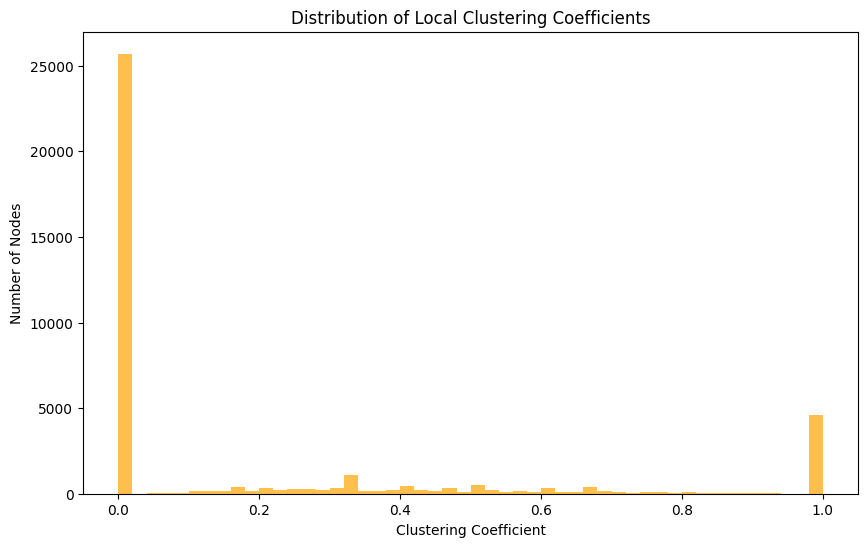

In [10]:
# Local clustering coefficients
local_clustering = nx.clustering(G)

# Clustering distribution
clustering_values = list(local_clustering.values())
clustering_stats = {
    'mean': np.mean(clustering_values),
    'median': np.median(clustering_values),
    'std': np.std(clustering_values),
    'max': max(clustering_values),
    'min': min(clustering_values)
}

print("\nClustering Coefficient Statistics:")
for stat, value in clustering_stats.items():
    print(f"{stat}: {value:.4f}")

# Plot clustering distribution
plt.figure(figsize=(10, 6))
plt.hist(clustering_values, bins=50, color='orange', alpha=0.7)
plt.title('Distribution of Local Clustering Coefficients')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Number of Nodes')
plt.show()


In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import collections
from scipy.stats import powerlaw
from networkx.algorithms import community

# Average Path Length Computation Using BFS
def average_path_length_bfs(G):
    """Calculate average shortest path length using BFS for largest connected component"""
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G_lcc = G.subgraph(largest_cc).copy()
        print(f"Graph not connected, using largest component with {len(G_lcc.nodes())} nodes")
    else:
        G_lcc = G
    
    all_path_lengths = []
    for source in G_lcc.nodes():
        # BFS from source to all other nodes
        lengths = nx.single_source_shortest_path_length(G_lcc, source)
        all_path_lengths.extend(lengths.values())
    
    avg_path_length = np.mean(all_path_lengths)
    return avg_path_length, all_path_lengths

# Calculate average path length
avg_path_length, all_paths = average_path_length_bfs(G)
print(f"Average Path Length: {avg_path_length:.2f}")


Graph not connected, using largest component with 16744 nodes
Average Path Length: 6.35


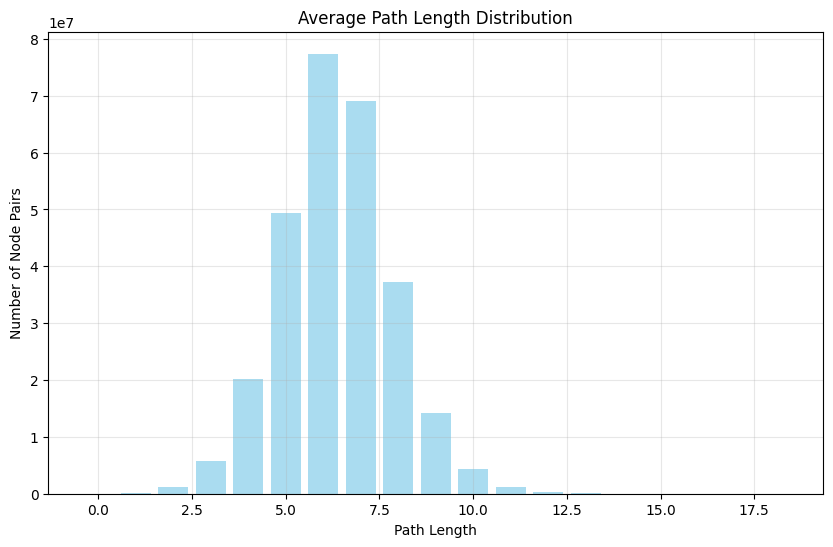

Path length range: 0 to 18
Most common path length: 6


In [12]:
# Plot path length distribution
plt.figure(figsize=(10, 6))
path_counts = collections.Counter(all_paths)
paths, counts = zip(*sorted(path_counts.items()))

plt.bar(paths, counts, color='skyblue', alpha=0.7)
plt.title('Average Path Length Distribution')
plt.xlabel('Path Length')
plt.ylabel('Number of Node Pairs')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Path length range: {min(all_paths)} to {max(all_paths)}")
print(f"Most common path length: {max(path_counts, key=path_counts.get)}")


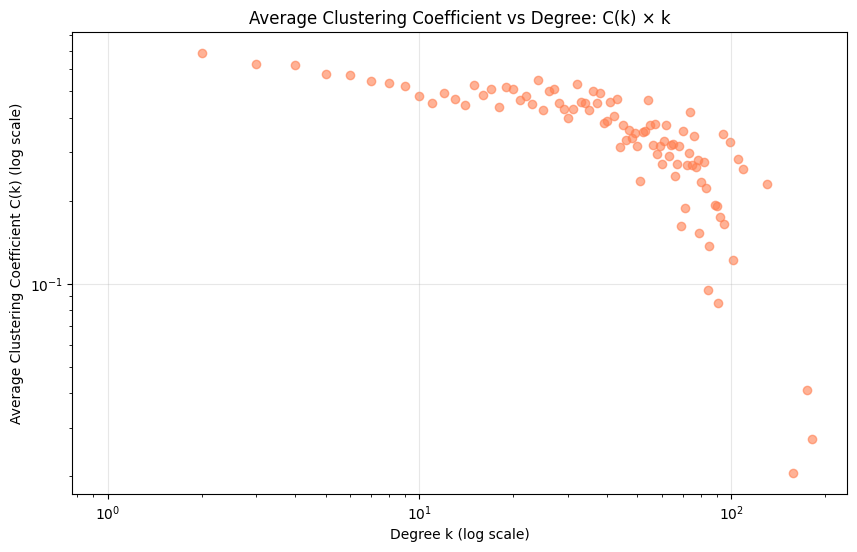

C(k) vs k relationship: slope = nan


In [13]:
def calculate_clustering_by_degree(G):
    """Calculate average clustering coefficient for each degree"""
    degree_clustering = {}
    
    for node in G.nodes():
        degree = G.degree(node)
        clustering = nx.clustering(G, node)
        
        if degree not in degree_clustering:
            degree_clustering[degree] = []
        degree_clustering[degree].append(clustering)
    
    # Calculate average clustering for each degree
    avg_clustering_k = {k: np.mean(v) for k, v in degree_clustering.items()}
    return avg_clustering_k

# Calculate C(k) vs k
avg_clustering_k = calculate_clustering_by_degree(G)

# Plot C(k) vs k
degrees = list(avg_clustering_k.keys())
clustering_coeffs = list(avg_clustering_k.values())

plt.figure(figsize=(10, 6))
plt.scatter(degrees, clustering_coeffs, alpha=0.6, color='coral')
plt.xscale('log')
plt.yscale('log')
plt.title('Average Clustering Coefficient vs Degree: C(k) × k')
plt.xlabel('Degree k (log scale)')
plt.ylabel('Average Clustering Coefficient C(k) (log scale)')
plt.grid(True, alpha=0.3)
plt.show()

# Check if C(k) ~ k^(-1) (small-world property)
log_k = np.log(degrees[1:])  # Skip degree 0
log_ck = np.log(clustering_coeffs[1:])
slope_ck, intercept_ck = np.polyfit(log_k, log_ck, 1)
print(f"C(k) vs k relationship: slope = {slope_ck:.3f}")
if slope_ck < -0.5:
    print("C(k) decreases with k, indicating hierarchical structure")


Power Law Analysis:
Slope (γ): -2.256
R-squared: 0.903
✓ Degree distribution follows POWER LAW


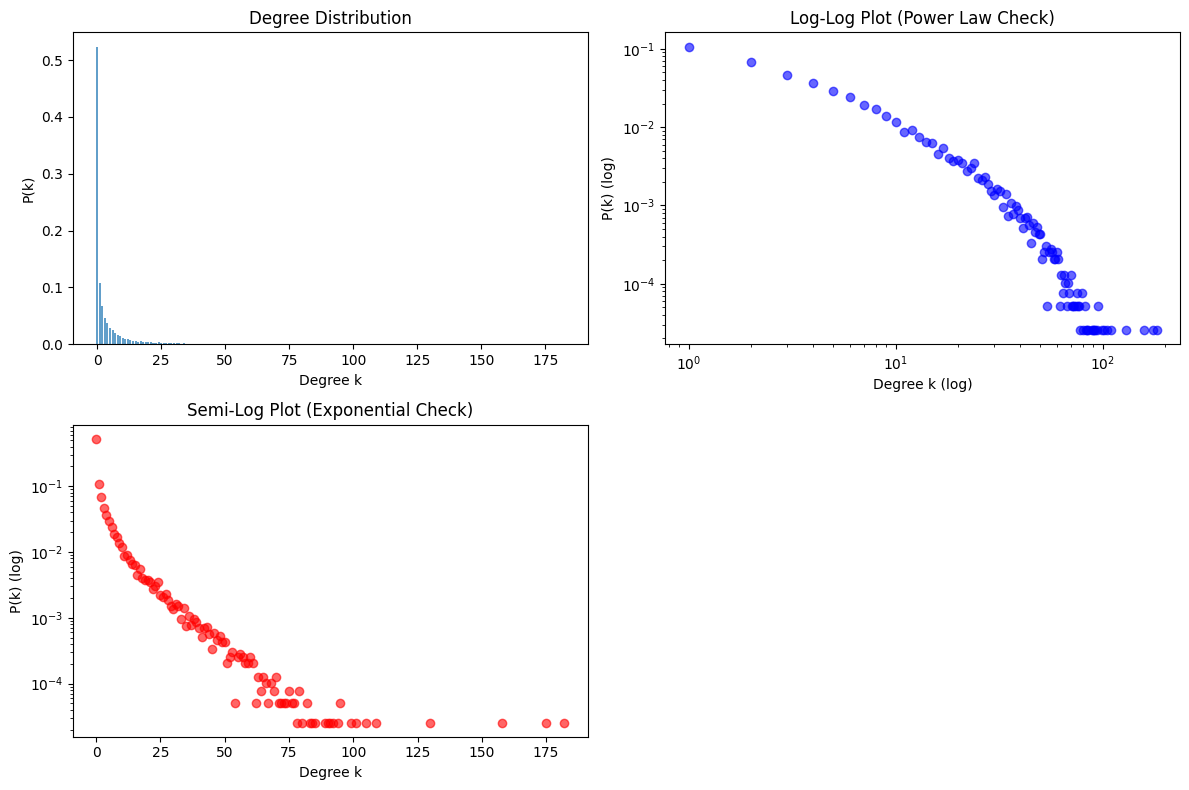

In [14]:
def analyze_degree_distribution(G):
    """Comprehensive analysis of degree distribution"""
    degree_sequence = [d for n, d in G.degree()]
    degree_counts = collections.Counter(degree_sequence)
    degrees, counts = zip(*sorted(degree_counts.items()))
    
    # Convert to probabilities
    total_nodes = sum(counts)
    prob_k = [c/total_nodes for c in counts]
    
    # Power law fit (excluding degree 0)
    valid_indices = [i for i, d in enumerate(degrees) if d > 0]
    log_degrees = [np.log(degrees[i]) for i in valid_indices]
    log_probs = [np.log(prob_k[i]) for i in valid_indices]
    
    slope_pl, intercept_pl = np.polyfit(log_degrees, log_probs, 1)
    
    # Exponential fit
    exp_slope, exp_intercept = np.polyfit(degrees, np.log(prob_k), 1)
    
    # Calculate R-squared for power law fit
    predicted_log_probs = [slope_pl * x + intercept_pl for x in log_degrees]
    ss_res = sum((log_probs[i] - predicted_log_probs[i])**2 for i in range(len(log_probs)))
    ss_tot = sum((log_probs[i] - np.mean(log_probs))**2 for i in range(len(log_probs)))
    r_squared_pl = 1 - (ss_res / ss_tot)
    
    return {
        'degrees': degrees,
        'probabilities': prob_k,
        'power_law_slope': slope_pl,
        'power_law_r2': r_squared_pl,
        'exp_slope': exp_slope
    }

# Analyze degree distribution
dist_analysis = analyze_degree_distribution(G)

print(f"Power Law Analysis:")
print(f"Slope (γ): {dist_analysis['power_law_slope']:.3f}")
print(f"R-squared: {dist_analysis['power_law_r2']:.3f}")

# Determine distribution type
if -3 < dist_analysis['power_law_slope'] < -2 and dist_analysis['power_law_r2'] > 0.8:
    print("✓ Degree distribution follows POWER LAW")
elif dist_analysis['exp_slope'] < -0.1:
    print("✓ Degree distribution follows EXPONENTIAL decay")
else:
    print("✓ Degree distribution follows LOG-NORMAL or other distribution")

# Plot degree distribution with fits
plt.figure(figsize=(12, 8))

# Original distribution
plt.subplot(2, 2, 1)
plt.bar(dist_analysis['degrees'], dist_analysis['probabilities'], alpha=0.7)
plt.title('Degree Distribution')
plt.xlabel('Degree k')
plt.ylabel('P(k)')

# Log-log plot for power law
plt.subplot(2, 2, 2)
plt.loglog(dist_analysis['degrees'][1:], dist_analysis['probabilities'][1:], 'bo', alpha=0.6)
plt.title('Log-Log Plot (Power Law Check)')
plt.xlabel('Degree k (log)')
plt.ylabel('P(k) (log)')

# Semi-log plot for exponential
plt.subplot(2, 2, 3)
plt.semilogy(dist_analysis['degrees'], dist_analysis['probabilities'], 'ro', alpha=0.6)
plt.title('Semi-Log Plot (Exponential Check)')
plt.xlabel('Degree k')
plt.ylabel('P(k) (log)')

plt.tight_layout()
plt.show()


In [15]:
def analyze_small_world_properties(G):
    """Check for small-world properties"""
    # Use largest connected component
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G_lcc = G.subgraph(largest_cc).copy()
    else:
        G_lcc = G
    
    # Calculate properties
    avg_clustering = nx.average_clustering(G_lcc)
    avg_path_length = nx.average_shortest_path_length(G_lcc)
    
    # Compare with random graph of same size
    n = G_lcc.number_of_nodes()
    m = G_lcc.number_of_edges()
    p = 2 * m / (n * (n - 1))  # Edge probability for random graph
    
    # Random graph properties
    C_random = p  # Expected clustering coefficient
    L_random = np.log(n) / np.log(2 * m / n)  # Expected path length
    
    # Small-world metrics
    sigma = (avg_clustering / C_random) / (avg_path_length / L_random)
    
    print(f"Small-World Analysis:")
    print(f"Average Clustering: {avg_clustering:.4f}")
    print(f"Average Path Length: {avg_path_length:.2f}")
    print(f"Random Graph Clustering: {C_random:.4f}")
    print(f"Random Graph Path Length: {L_random:.2f}")
    print(f"Small-world coefficient σ: {sigma:.2f}")
    
    if sigma > 1:
        print("✓ Network exhibits SMALL-WORLD properties")
    else:
        print("✗ Network does NOT exhibit small-world properties")
    
    return avg_clustering, avg_path_length, sigma

clustering, path_length, sigma = analyze_small_world_properties(G)


Small-World Analysis:
Average Clustering: 0.4707
Average Path Length: 6.35
Random Graph Clustering: 0.0005
Random Graph Path Length: 4.55
Small-world coefficient σ: 665.78
✓ Network exhibits SMALL-WORLD properties


Top 20 Hub Recipes:
--------------------------------------------------
 1. Recipe 29182 (italian)
    Connections: 182
    Ingredients: 10 total
    Sample ingredients: sliced ham, pillsbury™ refrigerated crescent dinner rolls, roasted red peppers, provolone cheese, hot pepper

 2. Recipe 1667 (mexican)
    Connections: 175
    Ingredients: 7 total
    Sample ingredients: pillsbury™ refrigerated crescent dinner rolls, mexican cheese blend, cooked chicken, refrigerated crescent rolls, red enchilada sauce

 3. Recipe 26165 (greek)
    Connections: 158
    Ingredients: 6 total
    Sample ingredients: fresh oregano, beef stock, baking potatoes, fresh oregano, beef stock

 4. Recipe 25996 (thai)
    Connections: 130
    Ingredients: 14 total
    Sample ingredients: coriander seeds, thai green curry paste, black peppercorns, lemon grass, yellow bell pepper

 5. Recipe 41524 (thai)
    Connections: 109
    Ingredients: 12 total
    Sample ingredients: lime zest, shrimp paste, boneless pork sh

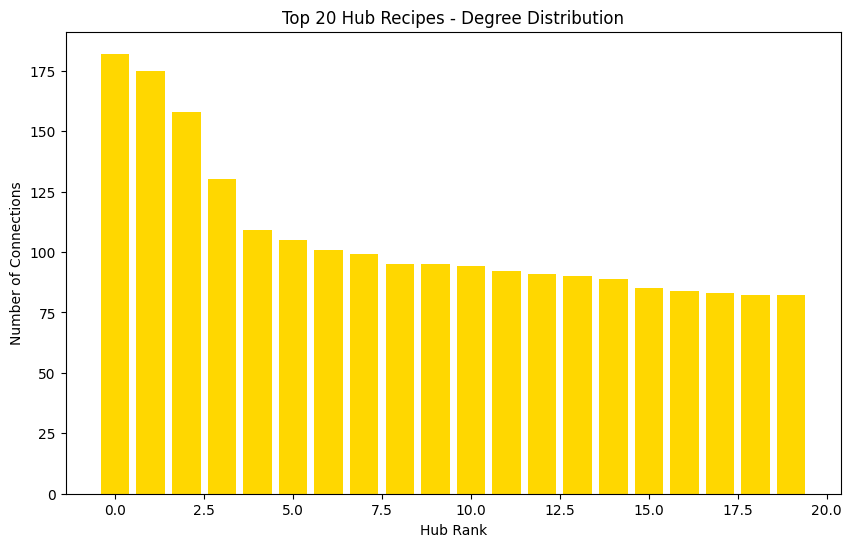

In [16]:
def analyze_hub_recipes(G, top_n=20):
    """Identify and analyze hub recipes"""
    degree_dict = dict(G.degree())
    sorted_recipes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
    
    print(f"Top {top_n} Hub Recipes:")
    print("-" * 50)
    
    hubs = []
    for i, (recipe_id, degree) in enumerate(sorted_recipes[:top_n]):
        # Get recipe information if available
        ingredients = G.nodes[recipe_id].get('ingredients', [])
        cuisine = G.nodes[recipe_id].get('cuisine', 'Unknown')
        
        print(f"{i+1:2d}. Recipe {recipe_id} ({cuisine})")
        print(f"    Connections: {degree}")
        print(f"    Ingredients: {len(ingredients)} total")
        if ingredients:
            print(f"    Sample ingredients: {', '.join(ingredients[:5])}")
        print()
        
        hubs.append({
            'recipe_id': recipe_id,
            'degree': degree,
            'cuisine': cuisine,
            'num_ingredients': len(ingredients)
        })
    
    return hubs

# Analyze hub recipes
hub_recipes = analyze_hub_recipes(G)

# Plot hub degree distribution
hub_degrees = [h['degree'] for h in hub_recipes]
plt.figure(figsize=(10, 6))
plt.bar(range(len(hub_degrees)), hub_degrees, color='gold')
plt.title('Top 20 Hub Recipes - Degree Distribution')
plt.xlabel('Hub Rank')
plt.ylabel('Number of Connections')
plt.show()


Community Detection Results:
Total communities: 21252
Largest communities: [1578, 1199, 1187, 955, 925, 910, 858, 836, 749, 691]

Community 1 (1 recipes):
  Top cuisines: [('greek', 1)]
  Common ingredients: ['romaine lettuce', 'black olives', 'grape tomatoes', 'seasoning', 'garbanzo beans']

Community 2 (1 recipes):
  Top cuisines: [('filipino', 1)]
  Common ingredients: ['cooking oil', 'grilled chicken breasts', 'chicken livers']

Community 3 (1 recipes):
  Top cuisines: [('indian', 1)]
  Common ingredients: ['wheat']

Community 4 (1 recipes):
  Top cuisines: [('jamaican', 1)]
  Common ingredients: ['plain flour', 'fresh ginger root']

Community 5 (1 recipes):
  Top cuisines: [('italian', 1)]
  Common ingredients: ['chopped tomatoes']


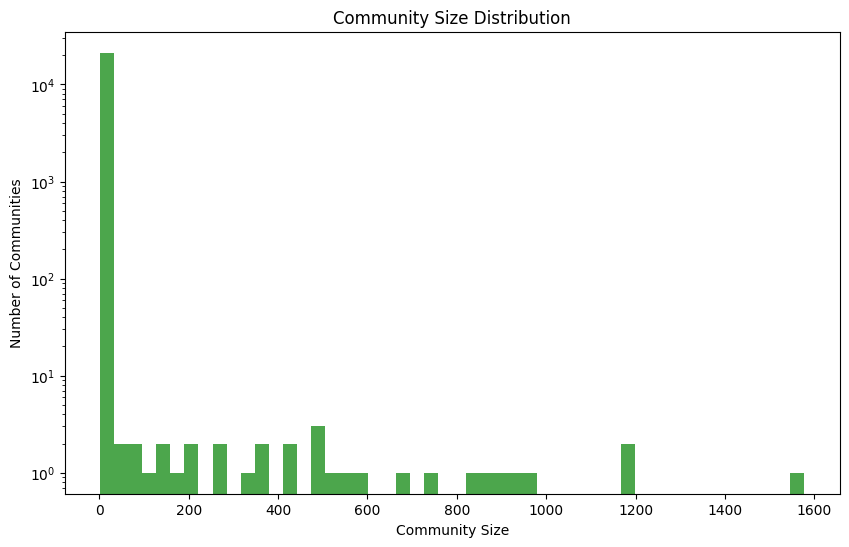

In [17]:
def analyze_ingredient_communities(G):
    """Detect and analyze ingredient-based communities"""
    # Community detection
    communities = community.louvain_communities(G, seed=42)
    
    print(f"Community Detection Results:")
    print(f"Total communities: {len(communities)}")
    
    # Analyze community sizes
    community_sizes = [len(c) for c in communities]
    community_sizes.sort(reverse=True)
    
    print(f"Largest communities: {community_sizes[:10]}")
    
    # Analyze top communities
    for i, comm in enumerate(communities[:5]):
        print(f"\nCommunity {i+1} ({len(comm)} recipes):")
        
        # Get cuisine distribution
        cuisine_count = {}
        ingredient_count = {}
        
        for recipe_id in list(comm)[:20]:  # Sample first 20 recipes
            if recipe_id in G.nodes:
                cuisine = G.nodes[recipe_id].get('cuisine', 'Unknown')
                ingredients = G.nodes[recipe_id].get('ingredients', [])
                
                cuisine_count[cuisine] = cuisine_count.get(cuisine, 0) + 1
                for ing in ingredients:
                    ingredient_count[ing] = ingredient_count.get(ing, 0) + 1
        
        # Top cuisines in community
        top_cuisines = sorted(cuisine_count.items(), key=lambda x: x[1], reverse=True)[:3]
        print(f"  Top cuisines: {top_cuisines}")
        
        # Top ingredients in community
        top_ingredients = sorted(ingredient_count.items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"  Common ingredients: {[ing for ing, count in top_ingredients]}")
    
    return communities

# Analyze communities
communities = analyze_ingredient_communities(G)

# Plot community size distribution
community_sizes = [len(c) for c in communities]
plt.figure(figsize=(10, 6))
plt.hist(community_sizes, bins=50, color='green', alpha=0.7)
plt.title('Community Size Distribution')
plt.xlabel('Community Size')
plt.ylabel('Number of Communities')
plt.yscale('log')
plt.show()


In [18]:
import numpy as np
import pandas as pd
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms import community

def cuisine_clustering_analysis(G):
    """Analyze how cuisines cluster within network communities"""
    # Detect communities using Louvain algorithm
    communities = list(community.louvain_communities(G, seed=42))
    
    print(f"Total communities detected: {len(communities)}")
    
    # Analyze cuisine composition in each community
    community_cuisine_data = []
    
    for i, comm in enumerate(communities):
        if len(comm) >= 5:  # Only analyze communities with 5+ recipes
            cuisines_in_comm = [G.nodes[node]['cuisine'] for node in comm if 'cuisine' in G.nodes[node]]
            cuisine_count = Counter(cuisines_in_comm)
            total_recipes = len(cuisines_in_comm)
            
            # Calculate cuisine diversity metrics
            entropy = -sum((count/total_recipes) * np.log2(count/total_recipes) 
                          for count in cuisine_count.values())
            dominant_cuisine = max(cuisine_count.items(), key=lambda x: x[1])
            purity = dominant_cuisine[1] / total_recipes
            
            community_cuisine_data.append({
                'community_id': i,
                'size': len(comm),
                'num_cuisines': len(cuisine_count),
                'entropy': entropy,
                'purity': purity,
                'dominant_cuisine': dominant_cuisine[0],
                'cuisine_distribution': dict(cuisine_count)
            })
    
    return community_cuisine_data, communities

# Run the analysis
community_data, communities = cuisine_clustering_analysis(G)

# Display results
print("\nCommunity Analysis Results:")
print("-" * 60)

for data in sorted(community_data, key=lambda x: x['size'], reverse=True)[:10]:
    print(f"Community {data['community_id']} ({data['size']} recipes):")
    print(f"  Cuisines: {data['num_cuisines']}")
    print(f"  Purity: {data['purity']:.2f} (1.0 = homogeneous)")
    print(f"  Entropy: {data['entropy']:.2f} (0 = homogeneous, higher = mixed)")
    print(f"  Dominant: {data['dominant_cuisine']}")
    
    # Show top 3 cuisines in community
    top_cuisines = sorted(data['cuisine_distribution'].items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"  Top cuisines: {top_cuisines}")
    print()


Total communities detected: 21252

Community Analysis Results:
------------------------------------------------------------
Community 19283 (1578 recipes):
  Cuisines: 20
  Purity: 0.80 (1.0 = homogeneous)
  Entropy: 1.33 (0 = homogeneous, higher = mixed)
  Dominant: mexican
  Top cuisines: [('mexican', 1269), ('southern_us', 92), ('italian', 77)]

Community 15089 (1199 recipes):
  Cuisines: 20
  Purity: 0.48 (1.0 = homogeneous)
  Entropy: 2.77 (0 = homogeneous, higher = mixed)
  Dominant: italian
  Top cuisines: [('italian', 580), ('french', 205), ('british', 66)]

Community 1434 (1187 recipes):
  Cuisines: 19
  Purity: 0.29 (1.0 = homogeneous)
  Entropy: 2.91 (0 = homogeneous, higher = mixed)
  Dominant: italian
  Top cuisines: [('italian', 344), ('french', 343), ('southern_us', 173)]

Community 4147 (955 recipes):
  Cuisines: 20
  Purity: 0.82 (1.0 = homogeneous)
  Entropy: 1.30 (0 = homogeneous, higher = mixed)
  Dominant: indian
  Top cuisines: [('indian', 780), ('japanese', 55), 

/tmp/ipykernel_36/2604580834.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08823529411764706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fusion_scores.loc[c1, c2] = fusion_matrix.loc[c1, c2] / cuisine_community_counts[c1]
/tmp/ipykernel_36/2604580834.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09558823529411764' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fusion_scores.loc[c1, c2] = fusion_matrix.loc[c1, c2] / cuisine_community_counts[c1]
/tmp/ipykernel_36/2604580834.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.09558823529411764' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fusio

Top Cuisine Fusion Pairs (most likely to cluster together):
------------------------------------------------------------
brazilian ↔ russian: 0.085
brazilian ↔ jamaican: 0.079
jamaican ↔ russian: 0.075
moroccan ↔ russian: 0.073
british ↔ russian: 0.073
brazilian ↔ moroccan: 0.071
brazilian ↔ british: 0.071
irish ↔ russian: 0.069
jamaican ↔ moroccan: 0.067
brazilian ↔ vietnamese: 0.064
british ↔ jamaican: 0.064
brazilian ↔ irish: 0.064
jamaican ↔ vietnamese: 0.064
greek ↔ russian: 0.063
brazilian ↔ spanish: 0.062


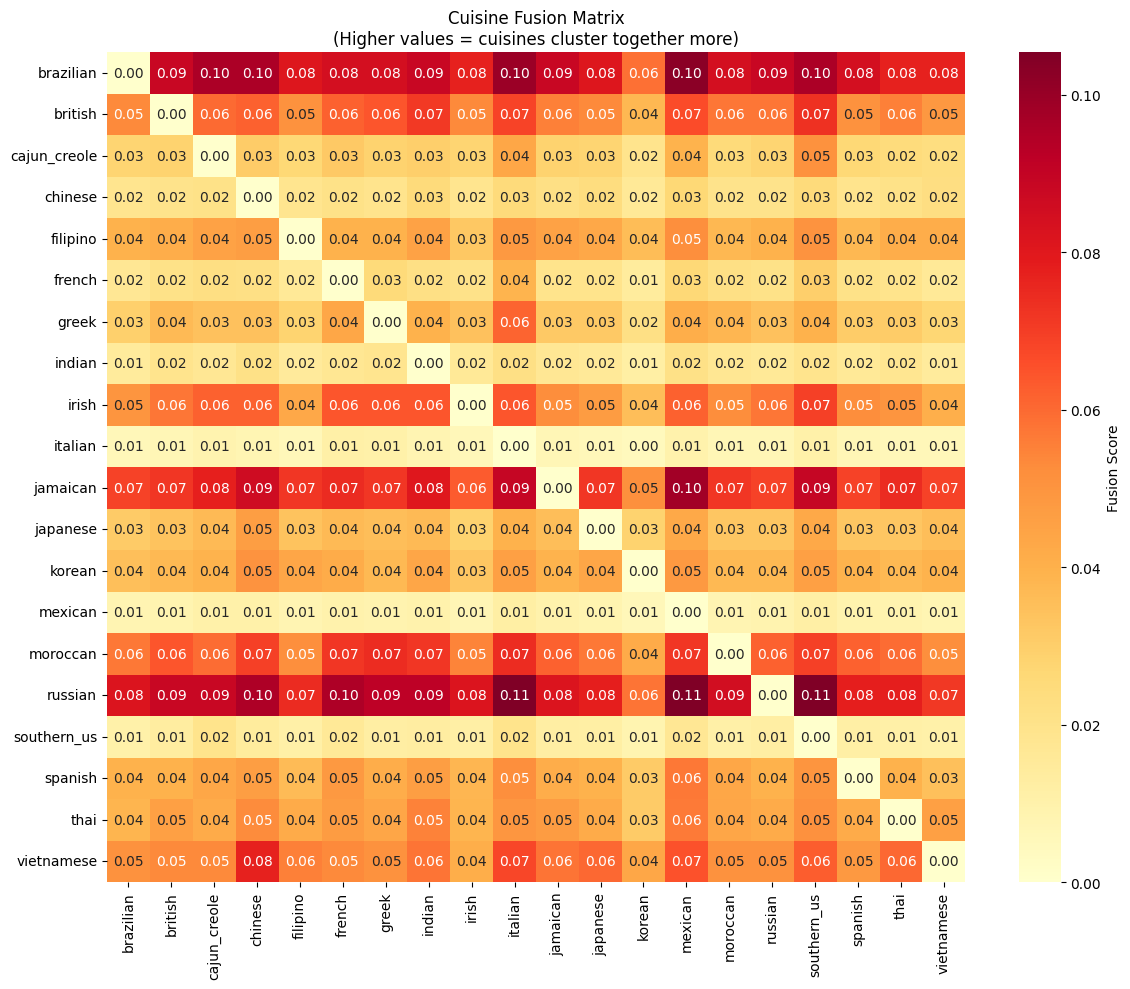

In [19]:
def calculate_cuisine_fusion_matrix(G, communities):
    """Calculate how often cuisine pairs appear together in communities"""
    
    # Get all unique cuisines
    all_cuisines = set(G.nodes[node].get('cuisine', '') for node in G.nodes() if 'cuisine' in G.nodes[node])
    all_cuisines.discard('')  # Remove empty cuisines
    
    # Initialize fusion matrix
    fusion_matrix = pd.DataFrame(0, index=sorted(all_cuisines), columns=sorted(all_cuisines))
    cuisine_community_counts = Counter()
    
    # Count co-occurrences in communities
    for comm in communities:
        cuisines_in_comm = [G.nodes[node]['cuisine'] for node in comm if 'cuisine' in G.nodes[node]]
        unique_cuisines = list(set(cuisines_in_comm))
        
        # Count individual cuisine appearances
        for cuisine in unique_cuisines:
            cuisine_community_counts[cuisine] += 1
        
        # Count pairwise co-occurrences
        for i, c1 in enumerate(unique_cuisines):
            for j, c2 in enumerate(unique_cuisines):
                if i != j:  # Don't count self-pairs
                    fusion_matrix.loc[c1, c2] += 1
    
    # Normalize by individual cuisine appearances to get fusion scores
    fusion_scores = fusion_matrix.copy()
    for c1 in fusion_matrix.index:
        for c2 in fusion_matrix.columns:
            if c1 != c2 and cuisine_community_counts[c1] > 0:
                fusion_scores.loc[c1, c2] = fusion_matrix.loc[c1, c2] / cuisine_community_counts[c1]
    
    return fusion_scores, cuisine_community_counts

# Calculate fusion matrix
fusion_scores, cuisine_counts = calculate_cuisine_fusion_matrix(G, communities)

# Display top fusion pairs
print("Top Cuisine Fusion Pairs (most likely to cluster together):")
print("-" * 60)

# Get upper triangle of matrix to avoid duplicates
fusion_pairs = []
for i, c1 in enumerate(fusion_scores.index):
    for j, c2 in enumerate(fusion_scores.columns):
        if i < j:  # Upper triangle only
            score = (fusion_scores.loc[c1, c2] + fusion_scores.loc[c2, c1]) / 2
            fusion_pairs.append((c1, c2, score))

# Sort by fusion score
fusion_pairs.sort(key=lambda x: x[2], reverse=True)

for c1, c2, score in fusion_pairs[:15]:
    print(f"{c1} ↔ {c2}: {score:.3f}")

# Plot fusion heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(fusion_scores, annot=True, cmap='YlOrRd', fmt='.2f', cbar_kws={'label': 'Fusion Score'})
plt.title('Cuisine Fusion Matrix\n(Higher values = cuisines cluster together more)')
plt.tight_layout()
plt.show()


In [20]:
def analyze_ingredient_overlap_between_cuisines(G):
    """Analyze ingredient sharing patterns between different cuisines"""
    
    # Group recipes by cuisine
    cuisine_ingredients = {}
    for node in G.nodes():
        if 'cuisine' in G.nodes[node] and 'ingredients' in G.nodes[node]:
            cuisine = G.nodes[node]['cuisine']
            ingredients = set(G.nodes[node]['ingredients'])
            
            if cuisine not in cuisine_ingredients:
                cuisine_ingredients[cuisine] = set()
            cuisine_ingredients[cuisine].update(ingredients)
    
    # Calculate Jaccard similarity between cuisines
    cuisine_similarity = {}
    cuisines = list(cuisine_ingredients.keys())
    
    for i, c1 in enumerate(cuisines):
        for j, c2 in enumerate(cuisines):
            if i < j:  # Upper triangle only
                ingredients1 = cuisine_ingredients[c1]
                ingredients2 = cuisine_ingredients[c2]
                
                intersection = len(ingredients1.intersection(ingredients2))
                union = len(ingredients1.union(ingredients2))
                
                if union > 0:
                    jaccard = intersection / union
                    overlap_count = intersection
                    cuisine_similarity[(c1, c2)] = {
                        'jaccard': jaccard,
                        'shared_ingredients': overlap_count,
                        'total_ingredients': union
                    }
    
    return cuisine_similarity, cuisine_ingredients

# Analyze ingredient overlap
ingredient_similarity, cuisine_ingredients = analyze_ingredient_overlap_between_cuisines(G)

print("Cuisine Ingredient Similarity (Jaccard Index):")
print("-" * 50)

# Sort by Jaccard similarity
sorted_similarities = sorted(ingredient_similarity.items(), key=lambda x: x[1]['jaccard'], reverse=True)

for (c1, c2), metrics in sorted_similarities[:15]:
    print(f"{c1} ↔ {c2}:")
    print(f"  Jaccard similarity: {metrics['jaccard']:.3f}")
    print(f"  Shared ingredients: {metrics['shared_ingredients']}")
    print(f"  Total unique ingredients: {metrics['total_ingredients']}")
    print()


Cuisine Ingredient Similarity (Jaccard Index):
--------------------------------------------------
italian ↔ french:
  Jaccard similarity: 0.583
  Shared ingredients: 1318
  Total unique ingredients: 2261

southern_us ↔ mexican:
  Jaccard similarity: 0.556
  Shared ingredients: 1306
  Total unique ingredients: 2348

italian ↔ mexican:
  Jaccard similarity: 0.550
  Shared ingredients: 1397
  Total unique ingredients: 2538

southern_us ↔ italian:
  Jaccard similarity: 0.542
  Shared ingredients: 1335
  Total unique ingredients: 2462

southern_us ↔ french:
  Jaccard similarity: 0.495
  Shared ingredients: 1092
  Total unique ingredients: 2206

chinese ↔ thai:
  Jaccard similarity: 0.488
  Shared ingredients: 778
  Total unique ingredients: 1595

southern_us ↔ cajun_creole:
  Jaccard similarity: 0.476
  Shared ingredients: 953
  Total unique ingredients: 2002

thai ↔ vietnamese:
  Jaccard similarity: 0.475
  Shared ingredients: 616
  Total unique ingredients: 1298

chinese ↔ japanese:
  Jac

In [21]:
def calculate_inter_cuisine_connectivity(G):
    """Calculate connectivity patterns between different cuisines"""
    
    # Count edges between and within cuisines
    intra_cuisine_edges = Counter()  # Edges within same cuisine
    inter_cuisine_edges = Counter()  # Edges between different cuisines
    cuisine_node_counts = Counter()
    
    for node in G.nodes():
        if 'cuisine' in G.nodes[node]:
            cuisine_node_counts[G.nodes[node]['cuisine']] += 1
    
    for u, v in G.edges():
        if 'cuisine' in G.nodes[u] and 'cuisine' in G.nodes[v]:
            cuisine_u = G.nodes[u]['cuisine']
            cuisine_v = G.nodes[v]['cuisine']
            
            if cuisine_u == cuisine_v:
                intra_cuisine_edges[cuisine_u] += 1
            else:
                # Sort to avoid counting (A,B) and (B,A) separately
                pair = tuple(sorted([cuisine_u, cuisine_v]))
                inter_cuisine_edges[pair] += 1
    
    # Calculate cuisine isolation scores
    isolation_scores = {}
    for cuisine in cuisine_node_counts:
        total_edges = intra_cuisine_edges[cuisine]
        inter_edges = sum(count for (c1, c2), count in inter_cuisine_edges.items() 
                         if c1 == cuisine or c2 == cuisine)
        
        if total_edges + inter_edges > 0:
            isolation_score = total_edges / (total_edges + inter_edges)
            isolation_scores[cuisine] = {
                'isolation': isolation_score,
                'intra_edges': total_edges,
                'inter_edges': inter_edges
            }
    
    return isolation_scores, inter_cuisine_edges

# Calculate connectivity patterns
isolation_scores, inter_edges = calculate_inter_cuisine_connectivity(G)

print("Cuisine Isolation Analysis:")
print("(1.0 = completely isolated, 0.0 = completely mixed)")
print("-" * 50)

for cuisine, metrics in sorted(isolation_scores.items(), key=lambda x: x[1]['isolation'], reverse=True):
    print(f"{cuisine}:")
    print(f"  Isolation score: {metrics['isolation']:.3f}")
    print(f"  Internal connections: {metrics['intra_edges']}")
    print(f"  External connections: {metrics['inter_edges']}")
    print()

print("\nTop Inter-Cuisine Connections:")
print("-" * 40)
for (c1, c2), count in sorted(inter_edges.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{c1} ↔ {c2}: {count} connections")


Cuisine Isolation Analysis:
(1.0 = completely isolated, 0.0 = completely mixed)
--------------------------------------------------
mexican:
  Isolation score: 0.769
  Internal connections: 10381
  External connections: 3124

korean:
  Isolation score: 0.640
  Internal connections: 1561
  External connections: 879

thai:
  Isolation score: 0.634
  Internal connections: 5921
  External connections: 3411

indian:
  Isolation score: 0.624
  Internal connections: 4418
  External connections: 2667

moroccan:
  Isolation score: 0.568
  Internal connections: 1675
  External connections: 1275

japanese:
  Isolation score: 0.523
  Internal connections: 2575
  External connections: 2349

chinese:
  Isolation score: 0.497
  Internal connections: 3448
  External connections: 3494

southern_us:
  Isolation score: 0.494
  Internal connections: 4524
  External connections: 4626

italian:
  Isolation score: 0.487
  Internal connections: 6986
  External connections: 7360

brazilian:
  Isolation score: 0

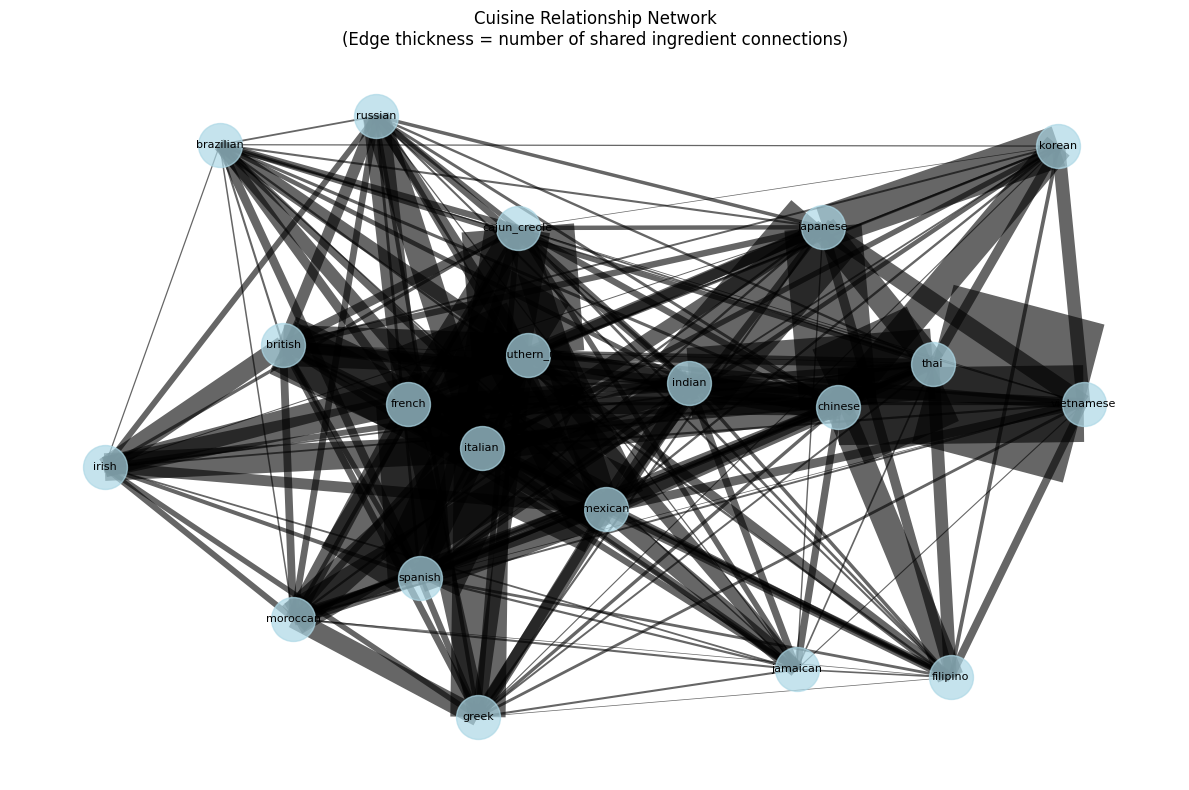

In [22]:
# Create cuisine relationship visualization
def plot_cuisine_network(G, communities):
    """Create a simplified network showing cuisine relationships"""
    
    # Create cuisine-level graph
    cuisine_graph = nx.Graph()
    cuisine_edges = Counter()
    
    # Add edges between cuisines based on recipe connections
    for u, v in G.edges():
        if 'cuisine' in G.nodes[u] and 'cuisine' in G.nodes[v]:
            c1, c2 = G.nodes[u]['cuisine'], G.nodes[v]['cuisine']
            if c1 != c2:
                edge = tuple(sorted([c1, c2]))
                cuisine_edges[edge] += 1
    
    # Add nodes and edges to cuisine graph
    for cuisine in set(G.nodes[n].get('cuisine', '') for n in G.nodes()):
        if cuisine:
            cuisine_graph.add_node(cuisine)
    
    for (c1, c2), weight in cuisine_edges.items():
        if weight >= 5:  # Only show significant connections
            cuisine_graph.add_edge(c1, c2, weight=weight)
    
    # Plot
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(cuisine_graph, k=2, iterations=50)
    
    # Draw nodes
    nx.draw_networkx_nodes(cuisine_graph, pos, node_size=1000, node_color='lightblue', alpha=0.7)
    
    # Draw edges with thickness proportional to weight
    edges = cuisine_graph.edges(data=True)
    for u, v, d in edges:
        nx.draw_networkx_edges(cuisine_graph, pos, [(u, v)], width=d['weight']/10, alpha=0.6)
    
    # Draw labels
    nx.draw_networkx_labels(cuisine_graph, pos, font_size=8)
    
    plt.title("Cuisine Relationship Network\n(Edge thickness = number of shared ingredient connections)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return cuisine_graph

cuisine_network = plot_cuisine_network(G, communities)
